In [2]:
#!/usr/bin/env python3
# Copyright 2022 ETH Zurich and University of Bologna.
# Licensed under the Apache License, Version 2.0, see LICENSE for details.
# SPDX-License-Identifier: Apache-2.0

import numpy as np
import torch
import torch.nn as nn
from torch.nn import functional as F
from torchvision import transforms
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
import argparse
import pathlib
import hjson
import random
import os

In [3]:
np.random.seed(42)
torch.manual_seed(42)
global verbose

In [4]:
def array_to_cstr(a):
    out = '{'
    if isinstance(a, np.ndarray):
        a = a.flat
    if isinstance(a, torch.Tensor):
        a = a.numpy().flat
    for el in a:
        out += '{}, '.format(el)
    out = out[:-2] + '}'
    return out

In [5]:
def emit_mnist_data(name='mnist', **kwargs):
    
    # constants
    IN_CH1 = kwargs['IN_CH1']
    IN_CH2 = kwargs['IN_CH2']
    OUT_CH = kwargs['OUT_CH']
    DATASET_SIZE = kwargs['DATASET_SIZE']
    
    # data
    # MAT_INPUT = kwargs['INPUT']
    # MAT_LABELS = kwargs['LABELS']

    # network init parameters from golden model
    MAT_WEIGHTS = kwargs['WEIGHTS']
    MAT_BIASES = kwargs['BIASES']

    IN_CH = IN_CH1*IN_CH2
    
    layer_str = ''
    layer_str += '#include "network.h"\n\n'
    layer_str += f'network_fp64_t {name}_t = {{\n'
    layer_str += f'\t.IN_CH1 = {IN_CH1},\n'
    layer_str += f'\t.IN_CH2 = {IN_CH2},\n'
    layer_str += f'\t.OUT_CH = {OUT_CH},\n'
    layer_str += f'\t.dtype = FP{kwargs["prec"]}\n'
    layer_str += '};\n\n\n'

    ctypes = {
        '64': 'double',
        '32': 'float',
        '16': '__fp16',
        'B16': '__bf16',
        '8': 'char'
    }

    dtype = ctypes[str(kwargs['prec'])]

    # network initialization
    layer_str += f'static {dtype} {name}_weights_dram [{OUT_CH}][{IN_CH}] = ' + array_to_cstr(MAT_WEIGHTS) + ';\n\n\n'
    layer_str += f'static {dtype} {name}_biases_dram [{OUT_CH}][{1}] = ' + array_to_cstr(MAT_BIASES) + ';\n\n\n'
    # layer_str += f'static {dtype} {name}_weight_grads_dram [{OUT_CH}][{IN_CH}] = ' + array_to_cstr(MAT_WEIGHT_GRADS) + ';\n\n\n'
    # layer_str += f'static {dtype} {name}_bias_grads_dram [{OUT_CH}][{1}] = ' + array_to_cstr(MAT_BIAS_GRADS) + ';\n\n\n'


    # input data
    # layer_str += f'static {dtype} {name}_images_dram [{DATASET_SIZE*IN_CH}][{1}] = ' + array_to_cstr(MAT_INPUT) + ';\n\n\n'
    # layer_str += f'static uint32_t {name}_labels_dram [{DATASET_SIZE}][{1}] = ' + array_to_cstr(MAT_LABELS) + ';\n\n\n'
    #layer_str += f'static {dtype} {name}_images_dram [{IN_CH}][{1}] = ' + array_to_cstr(MAT_INPUT) + ';\n\n\n'
    #layer_str += f'static uint32_t {name}_labels_dram[{1}] = ' + array_to_cstr(MAT_LABELS) + ';\n\n\n'

    return layer_str


In [6]:
def emit_mnist_header_file(layer_type: str, data_type: str, **kwargs):

    file_path = '/scratch1/msc22f11/snitch/sw/applications/data/'
    emit_str = "// Copyright 2022 ETH Zurich and University of Bologna.\n" + \
               "// Licensed under the Apache License, Version 2.0, see LICENSE for details.\n" + \
               "// SPDX-License-Identifier: Apache-2.0\n\n"

    if(layer_type == 'mnist'):
        if(data_type == 'FP64'):
            file = file_path + 'data_fp64_mnist.h'
            emit_str += emit_mnist_data(**kwargs)
        elif(data_type == 'FP32'):
            file = file_path + 'data_fp32_mnist.h'
            emit_str += emit_mnist_data(**kwargs)
        elif(data_type == 'FP16'):
            file = file_path + 'data_fp16_test_mnist.h'
            emit_str += emit_mnist_data(**kwargs)
        elif(data_type == 'BF16'):
            file = file_path + 'data_bf16_mnist.h'
            emit_str += emit_mnist_data(**kwargs)
        elif(data_type == 'FP8'):
            file = file_path + 'data_fp8_test_mnist.h'
            emit_str += emit_mnist_data(**kwargs)

    #  # if file does not exist create it
    # if(not os.path.exists(file)):
    #     pathlib.Path(file).touch()

    with open(file, 'w') as f:
        f.write(emit_str)

    print(f'Wrote {file}')


In [7]:
# download MNIST dataset using DataLoader

transform = transforms.Compose(
    [
        transforms.ToTensor()
    ]
)

PATH_DATASETS = os.environ.get("PATH_DATASETS", ".")
mnist_dataset = MNIST(PATH_DATASETS, train=True, transform=transform, download=True)

# set seeds for reproducability 
g = torch.Generator()
g.manual_seed(42)

def seed_worker(worker_id):
    worker_seed = torch.initial_seed % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

mnist_dl = DataLoader(mnist_dataset, worker_init_fn=seed_worker, generator=g)

In [8]:
in_ch = 28*28
out_ch = 10

class LinLayer(nn.Module):
    def __init__(self):
        super(LinLayer, self).__init__()
        torch.manual_seed(42)
        self.lin = nn.Linear(in_ch, out_ch, dtype=torch.float64)

    def forward(self, x):
        torch.manual_seed(42)
        out = self.lin(x.view(x.size(0), -1))
        return out

In [9]:
# import optimizers
import torch.optim as optim
torch.manual_seed(42)

net = LinLayer()
weights = net.lin.weight
print("initial weights shape: {}".format(weights.shape))
biases = net.lin.bias
print("initial biases shape: {}".format(biases.shape))

initial weights shape: torch.Size([10, 784])
initial biases shape: torch.Size([10])


In [10]:
# special handling for FP8 type where we set up the conversion first
import pathlib
import ctypes

from ctypes import c_uint8, c_double, c_float
from ctypes import byref, Structure


class flexfloat_desc_t(Structure):
    _fields_ = [("exp_bits", c_uint8), ("frac_bits", c_uint8)]


class flexfloat_t(Structure):
    _fields_ = [("value", c_double), ("desc", flexfloat_desc_t)]


fp64_desc = flexfloat_desc_t(11, 52)
fp32_desc = flexfloat_desc_t(8, 23)
fp16_desc = flexfloat_desc_t(5, 11)
fp16alt_desc = flexfloat_desc_t(8, 7)
fp8_desc = flexfloat_desc_t(5, 2)
fp8alt_desc = flexfloat_desc_t(4, 3)

lib_path = "/usr/scratch/badile31/msc22f11/msc22f11/PlayGround/flexfloat/src/libflexfloat.so"
ff_lib = ctypes.CDLL(lib_path)

ff_get_float = ff_lib.ff_get_float
ff_get_float.restype = c_float


class ff:
    def __init__(self, value: float, desc: flexfloat_desc_t = fp64_desc):
        self.desc = desc
        self.value = value
        self.a = flexfloat_t(value, desc)
        ff_lib.ff_init_float(byref(self.a), c_float(value), desc)

    def __add__(self, b):
        ff_res = flexfloat_t(0.0, self.desc)
        ff_lib.ff_add(byref(ff_res), byref(self.a), byref(b.a))
        return 0

In [11]:
a = ff(3.0, fp32_desc)
b = ff(4.0, fp32_desc)

ff_a = flexfloat_t(0.0, fp8_desc)
# ff_lib.flexfloat_get_bits(byref(ff_a))
# print("ff_a bits: {}".format(ff_lib.flexfloat_get_bits(byref(ff_a))))
ff_b = flexfloat_t(0.0, fp8_desc)
ff_c = flexfloat_t(0.0, fp8_desc)

ff_lib.ff_init_float(byref(ff_a), c_float(1.0), fp8_desc)
ff_lib.ff_init_float(byref(ff_b), c_float(2.0), fp8_desc)
ff_lib.ff_init_float(byref(ff_c), c_float(3.0), fp8_desc)

ff_lib.ff_add(byref(ff_c), byref(ff_b), byref(ff_c))

ff_c_bits = ff_lib.flexfloat_get_bits(byref(ff_c))
print("ff_c: {}".format(ff_c_bits))
# convert to binary with leading zeros
print("ff_c bits: 0b{}".format(bin(ff_c_bits)[2:].zfill(8)))	
# print ff_c as 16 bit binary

c = ff_lib.ff_get_float(byref(ff_c))
print(c)

ff_c: 69
ff_c bits: 0b01000101
5.0


In [12]:
ff_result = flexfloat_t(0.0, fp16_desc)
ff_image = flexfloat_t(0.0196, fp16_desc)
ff_image_bits = ff_lib.flexfloat_get_bits(byref(ff_image))
ff_bgrad = flexfloat_t(0.0001, fp16_desc)
ff_bgrad_bits = ff_lib.flexfloat_get_bits(byref(ff_bgrad))

# multiply image by bgrad
ff_lib.ff_mul(byref(ff_result), byref(ff_image), byref(ff_bgrad))
ff_result_bits = ff_lib.flexfloat_get_bits(byref(ff_result))
print("ff_image: {}".format(ff_image_bits))
print("ff_image bits: 0b{}".format(bin(ff_image_bits)[2:].zfill(16)))	
print("ff_bgrad: {}".format(ff_bgrad_bits))
print("ff_bgrad bits: 0b{}".format(bin(ff_bgrad_bits)[2:].zfill(16)))
print("ff_result: {}".format(ff_result_bits))
print("ff_result bits: 0b{}".format(bin(ff_result_bits)[2:].zfill(16)))
# print("result bits: 0b{}".format(bin(result)[2:].zfill(16)))
# get float value
ff_result_float = ff_lib.ff_get_float(byref(ff_result))
print("ff_result float: {}".format(ff_result_float))

ff_image: 18953
ff_image bits: 0b0100101000001001
ff_bgrad: 3355
ff_bgrad bits: 0b0000110100011011
ff_result: 66
ff_result bits: 0b0000000001000010
ff_result float: 1.9669532775878906e-06


In [13]:
# function to convert float32 to binary representation
import struct

def float32_to_bin(value):
    return ''.join(f'{c:0>8b}' for c in struct.pack('!f', value))

In [14]:
"""
We have to handle denormalized numbers:
    
    +INF will be represented in FP8 as 0 11111 00 
    -INF will be represented in FP8 as 1 11111 00
    +0 will be represented in FP8 as 0 00000 00
    -0 will be represented in FP8 as 1 00000 00
    NaN will be represented in FP8 as X 11111 MM (at least one of the MMM bits is set, sign bit is don't care)

According to https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=8556098 denormalized transprecision numbers
will be represented by their high precision counterparts. In these cases we have to make sure that we do not adjust
the exponent. In the other cases we adjust the exponent and cut the mantissa.
"""

from numpy import binary_repr

# this function returns an 8 character string representing the binary representation of the FP8 number
def float32_to_fp8(value):
    max_exp_fp32 = int('11111111', 2)
    min_exp_fp32 = int('00000000', 2)
    exp_bias_fp32 = 2 ** (8 - 1) - 1
    exp_bias_fp8 = 2 ** (5 - 1) - 1
    # get the binary representation of the number
    binstr = float32_to_bin(value)
    # extract sign, exponent and mantissa bits
    sign = binstr[0]
    exponent = binstr[1:9]
    mantissa = binstr[9:]
    # check if the number is denormalized
    # we start by checking if all exponent bits are asserted
    if(int(exponent) == max_exp_fp32):
        # if so, we check if the mantissa is all zeros (will result in +/-INF)
        if(int(mantissa) == 0):
            return '0b' + sign + exponent[:5] + mantissa[:2]
        # if not, we have to return a NaN
        else:
            return '0b' + sign + exponent[:5] + '01'
    # if both exponent and mantissa are zero we will return +/-0
    elif (int(exponent) == min_exp_fp32 and int(mantissa) == 0): 
        return '0b' + sign + exponent[:5] + mantissa[:2]
    else :
        # if not, we adjust the exponent and cut the mantissa
        exponent_fp8 = binary_repr(int(exponent, 2) - exp_bias_fp32 + exp_bias_fp8, width=5)
        mantissa_fp8 = mantissa[:2]
        return '0b' + sign + exponent_fp8 + mantissa_fp8


In [15]:
# exponent is stored in two's complement
def twos_comp(val, bits):
    """compute the 2's complement of int value val"""
    if (val & (1 << (bits - 1))) != 0: # if sign bit is set e.g., 8bit: 128-255
        val = val - (1 << bits)        # compute negative value
    return val  

In [16]:
def convert_to_fp8_decimal(binstr):

    # extract sign, exponent and mantissa bits
    sign = binstr[0]
    num_sign_bits = 1
    # print(f'Sign:     ({num_sign_bits} bit)  = {sign}')
    exponent = binstr[1:6]
    num_exp_bits = len(exponent)
    # print(f'Exponent: ({num_exp_bits} bit)  = {exponent}')
    mantissa = binstr[6:]
    num_mant_bits = len(mantissa)
    # print(f'Mantissa: ({num_mant_bits} bit) = {mantissa}')

    exp_bias_fp8 = 2 ** (5 - 1) - 1
    dec_val_fp8 = (-1)**(int(sign, 2)) * (1 + (int(mantissa, 2))/(2**num_mant_bits)) * 2**(twos_comp(int(exponent, 2), num_exp_bits) - exp_bias_fp8)
    if(int(sign, 2) == 0 and int(exponent, 2) == 0 and int(mantissa, 2) == 0):
        dec_val_fp8 = 0
    # print("\nBinary to floating point number (FP8) conversion using formula: ", dec_val_fp8)
    return dec_val_fp8
    

In [17]:
# define the special FP8 values
fp8_nans = ['01111101', '01111110', '01111111', '11111101', '11111110', '11111111']
# print fp8_nans as integers
for nan in fp8_nans:
    print(f' NaN: {nan} = {int(nan, 2)}')
fp8_pinf = '01111100'
print(f'+INF: {fp8_pinf} = {int(fp8_pinf, 2)}')
fp8_ninf = '11111100'
print(f'-INF: {fp8_ninf} = {int(fp8_ninf, 2)}')

 NaN: 01111101 = 125
 NaN: 01111110 = 126
 NaN: 01111111 = 127
 NaN: 11111101 = 253
 NaN: 11111110 = 254
 NaN: 11111111 = 255
+INF: 01111100 = 124
-INF: 11111100 = 252


In [18]:
fp8_int_values = range(0, 256)
# remove the special FP8 values
fp8_int_values = [x for x in fp8_int_values if x not in [int(nan, 2) for nan in fp8_nans] + [int(fp8_pinf, 2), int(fp8_ninf, 2)]]

In [19]:
import random
def clear_special_values(data_np):
    nan_cnt = 0
    inf_cnt = 0
    for val, idx in zip(data_np, range(len(data_np))):
        if(val in [int(nan, 2) for nan in fp8_nans]):
            print(f'Found NaN at index {idx}')
            data_np[idx] = random.choice(fp8_int_values)
            print(f'Randomly replaced NaN with {data_np[idx]}')
            nan_cnt += 1
        elif(val == int(fp8_pinf, 2) or val == int(fp8_ninf, 2)):
            print(f'Found INF at index {idx}')
            data_np[idx] = random.choice(fp8_int_values)
            print(f'Randomly replaced INF with {data_np[idx]}')
            inf_cnt += 1 

    print(f'NaN count: {nan_cnt}')
    print(f'INF count: {inf_cnt}')

    return data_np

In [20]:
def convert_to_target_format(data_np, prec):
    if prec == 64:
        return data_np.astype(np.float64)
    elif prec == 32:
        return data_np.astype(np.float32)
    elif prec == 16:
        return data_np.astype(np.float16)
    elif prec == 8:
        data_np = data_np.astype(np.float32)
        # convert to FP8
        data_fp8 = np.array([float32_to_fp8(val) for val in data_np])
        # clear special values
        data_fp8 = clear_special_values(data_fp8)
        return data_fp8

In [21]:
weights.detach().numpy().flatten()

array([-0.03156039, -0.0312207 , -0.02688671, ...,  0.03123467,
        0.00186213,  0.0296352 ])

In [19]:
# print data type and shape
print(f'Original data type: {weights.detach().numpy().flatten().dtype}')
print(f'Original data shape: {weights.detach().numpy().flatten().shape}')
# convert to target format
weights_fp64 = convert_to_target_format(weights.detach().numpy().flatten(), 64)
biases_fp64 = convert_to_target_format(biases.detach().numpy().flatten(), 64)
print(f'Weights - FP64 data type: {weights_fp64.dtype}')
print(f'Weights - FP64 data shape: {weights_fp64.shape}')
print(f'Biases - FP64 data type: {biases_fp64.dtype}')
print(f'Biases - FP64 data shape: {biases_fp64.shape}')
weights_fp32 = convert_to_target_format(weights.detach().numpy().flatten(), 32)
biases_fp32 = convert_to_target_format(biases.detach().numpy().flatten(), 32)
print(f'Weights - FP32 data type: {weights_fp32.dtype}')
print(f'Biases - FP32 data shape: {weights_fp32.shape}')
print(f'Biases - FP32 data type: {biases_fp32.dtype}')
print(f'Biases - FP32 data shape: {biases_fp32.shape}')
weights_fp16 = convert_to_target_format(weights.detach().numpy().flatten(), 16)
biases_fp16 = convert_to_target_format(biases.detach().numpy().flatten(), 16)
print(f'Weights - FP16 data type: {weights_fp16.dtype}')
print(f'Weights - FP16 data shape: {weights_fp16.shape}')
print(f'Biases - FP16 data type: {biases_fp16.dtype}')
print(f'Biases - FP16 data shape: {biases_fp16.shape}')
weights_fp8 = convert_to_target_format(weights.detach().numpy().flatten(), 8)
biases_fp8 = convert_to_target_format(biases.detach().numpy().flatten(), 8)
print(f'Weights - FP8 data type: {weights_fp8.dtype}')
print(f'Weights - FP8 data shape: {weights_fp8.shape}')
print(f'Biases - FP8 data type: {biases_fp8.dtype}')
print(f'Biases - FP8 data shape: {biases_fp8.shape}')

Original data type: float64
Original data shape: (7840,)
Weights - FP64 data type: float64
Weights - FP64 data shape: (7840,)
Biases - FP64 data type: float64
Biases - FP64 data shape: (10,)
Weights - FP32 data type: float32
Biases - FP32 data shape: (7840,)
Biases - FP32 data type: float32
Biases - FP32 data shape: (10,)
Weights - FP16 data type: float16
Weights - FP16 data shape: (7840,)
Biases - FP16 data type: float16
Biases - FP16 data shape: (10,)
NaN count: 0
INF count: 0
NaN count: 0
INF count: 0
Weights - FP8 data type: <U10
Weights - FP8 data shape: (7840,)
Biases - FP8 data type: <U10
Biases - FP8 data shape: (10,)


In [21]:
kwargs = {
            'IN_CH1': 28,
            'IN_CH2': 28,
            'OUT_CH': 10,
            'DATASET_SIZE': 5,
            'WEIGHTS': weights_fp16,
            'BIASES': biases_fp16,
            'prec': 16
}

In [57]:
emit_mnist_header_file('mnist', 'FP16', **kwargs)

Wrote /scratch1/msc22f11/snitch/sw/applications/data/data_fp16_test_mnist.h


In [20]:
## VERIFICATION CHECK
# manually compute the output of the linear layer
first_im, first_label = next(iter(mnist_dl))

In [21]:
# calculate the activations of the linear layer
activations = first_im.view(-1, 28*28).to(torch.float64) @ weights.t() + biases
print(f'Activations shape: {activations.shape}')
print(f'Activations: {activations}')
# compute the softmax
softmax = torch.nn.Softmax(dim=1)
softmax_out = softmax(activations)
print(f'\nSoftmax output shape: {softmax_out.shape}')
print(f'Softmax output: {softmax_out}')
# compute the bias gradient
bias_grad = softmax_out - torch.nn.functional.one_hot(first_label, num_classes=10).to(torch.float64)
print(f'\nBias gradient shape: {bias_grad.shape}')
print(f'Bias gradient: {bias_grad}')
# compute the weight gradient
weight_grad = bias_grad.t() @ first_im.view(-1, 28*28).to(torch.float64)
print(f'\nWeight gradient shape: {weight_grad.shape}')
# compute the checksum of the weight gradient for each column
weight_grad_checksum = weight_grad.sum(axis=1)
print(f'Weight gradient checksum shape: {weight_grad_checksum.shape}')
print(f'Weight gradient checksum: {weight_grad_checksum}')
# compute the updated weights
updated_weights = weights - 0.5 * weight_grad
print(f'\nUpdated weights shape: {updated_weights.shape}')
# compute the checksum of the updated weights for each column
updated_weights_checksum = updated_weights.sum(axis=1)
print(f'Updated weights checksum shape: {updated_weights_checksum.shape}')
print(f'Updated weights checksum: {updated_weights_checksum}')
# compute the updated biases
updated_biases = biases - 0.5 * bias_grad.sum(axis=0)
print(f'\nUpdated biases shape: {updated_biases.shape}')
print(f'Updated biases: {updated_biases}')

Activations shape: torch.Size([1, 10])
Activations: tensor([[ 0.0534,  0.1614,  0.2875,  0.0104,  0.2178, -0.2916, -0.0588,  0.4338,
          0.1176,  0.0230]], dtype=torch.float64, grad_fn=<AddBackward0>)

Softmax output shape: torch.Size([1, 10])
Softmax output: tensor([[0.0942, 0.1049, 0.1190, 0.0902, 0.1110, 0.0667, 0.0842, 0.1378, 0.1004,
         0.0914]], dtype=torch.float64, grad_fn=<SoftmaxBackward0>)

Bias gradient shape: torch.Size([1, 10])
Bias gradient: tensor([[ 0.0942,  0.1049,  0.1190,  0.0902,  0.1110, -0.9333,  0.0842,  0.1378,
          0.1004,  0.0914]], dtype=torch.float64, grad_fn=<SubBackward0>)

Weight gradient shape: torch.Size([10, 784])
Weight gradient checksum shape: torch.Size([10])
Weight gradient checksum: tensor([  10.1679,   11.3281,   12.8498,    9.7401,   11.9851, -100.7401,
           9.0890,   14.8742,   10.8421,    9.8640], dtype=torch.float64,
       grad_fn=<SumBackward1>)

Updated weights shape: torch.Size([10, 784])
Updated weights checksum sh

In [22]:
(weight_grad**2).shape

torch.Size([10, 784])

In [33]:
# determine the norm of the weight gradient
weight_grad_norm = torch.norm(weight_grad)
print(f'Weight gradient norm: {weight_grad_norm}')
# create zero tensor of the same shape as the weight gradient
weight_grad_norm_tensor = torch.zeros_like(weight_grad)
# manually compute the square of the weight gradient
for i in range(weight_grad.shape[0]):
    for j in range(weight_grad.shape[1]):
        weight_grad_norm_tensor[i, j] = weight_grad[i, j]*weight_grad[i, j]
# determine the norm of the weight gradient manually
weight_grad_norm_manual = torch.sqrt(torch.sum(weight_grad**2))
print(f'Weight gradient norm (manual): {weight_grad_norm_manual}')
max_norm = 5
# compute the clipped gradient manually
clipped_weight_grad = weight_grad * torch.min(max_norm / weight_grad_norm, torch.tensor(1.0))
# clipped_weight_grad
# determine the norm of the clipped gradient manually
clipped_weight_grad_norm_manual = torch.sqrt(torch.sum(clipped_weight_grad**2))
print(f'Clipped weight gradient norm (manual): {clipped_weight_grad_norm_manual}')

Weight gradient norm: 9.41358745683761
Weight gradient norm (manual): 9.413587456837613
Clipped weight gradient norm (manual): 5.000000000000002


In [34]:
weight_grad_norm_tensor == weight_grad**2

tensor([[True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True],
        ...,
        [True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True]])

In [29]:
torch.sqrt(torch.sum(weight_grad))

tensor(1.2467e-07, dtype=torch.float64, grad_fn=<SqrtBackward0>)

In [24]:
weight_grad.t() * weight_grad.t() == weight_grad.t()**2

tensor([[True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True],
        ...,
        [True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True]])

In [36]:
torch.tensor(1.0)

tensor(1.)

In [35]:
torch.min(max_norm / weight_grad_norm, torch.tensor(1.0))

tensor(0.5311, dtype=torch.float64, grad_fn=<MinimumBackward0>)

In [25]:
# get full training routine for FP16
# transform FP16 weights back to original shape
weights_fp16t = weights_fp16.reshape(10, 28*28)
# convert numpy array to torch tensor
weights_fp16t = torch.from_numpy(weights_fp16t)
# transform FP16 biases back to original shape
biases_fp16t = biases_fp16.reshape(10)
# convert numpy array to torch tensor
biases_fp16t = torch.from_numpy(biases_fp16t)
it = iter(mnist_dl)
for i in range(10):
    print(f'--------------- Iteration {i} ---------------')
    im, label = next(it)
    linear_output_fp16 = im.view(-1, 28*28).to(torch.float16) @ weights_fp16t.t() + biases_fp16t
    print(f'\nFP16 Linear output: {linear_output_fp16}')
    # compute the softmax (have to upcast as FP16 is not supported)
    softmax_output = torch.nn.Softmax(dim=1)(linear_output_fp16.to(torch.float32))
    # downcast back to FP16
    softmax_output_fp16 = softmax_output.to(torch.float16)
    print(f'\nFP16 Softmax output: {softmax_output_fp16}')
    # compute the bias gradient
    bias_grad_fp16 = softmax_output_fp16 - torch.nn.functional.one_hot(label, num_classes=10).to(torch.float16)
    print(f'\nFP16 Bias gradient: {bias_grad_fp16}')
    # compute the weight gradient
    weight_grad_fp16 = bias_grad_fp16.t() @ im.view(-1, 28*28).to(torch.float16)
    # compute the checksum of the weight gradient for each column
    weight_grad_checksum_fp16 = weight_grad_fp16.sum(axis=1)
    print(f'\nFP16 Weight gradient checksum: {weight_grad_checksum_fp16}')
    # compute the updated weights
    weights_fp16t = weights_fp16t - 0.5 * weight_grad_fp16
    # compute the checksum of the updated weights for each column
    updated_weights_checksum_fp16 = weights_fp16t.sum(axis=1)
    print(f'\nFP16 Updated weights checksum: {updated_weights_checksum_fp16}')
    # compute the updated biases
    biases_fp16t = biases_fp16t - 0.5 * bias_grad_fp16.sum(axis=0)
    print(f'\nFP16 Updated biases: {biases_fp16t}')
    print(f'--------------- Iteration {i} completed --------------- \n')


--------------- Iteration 0 ---------------

FP16 Linear output: tensor([[ 0.0532,  0.1615,  0.2876,  0.0099,  0.2178, -0.2915, -0.0587,  0.4343,
          0.1176,  0.0231]], dtype=torch.float16)

FP16 Softmax output: tensor([[0.0942, 0.1049, 0.1191, 0.0902, 0.1110, 0.0667, 0.0842, 0.1378, 0.1005,
         0.0914]], dtype=torch.float16)

FP16 Bias gradient: tensor([[ 0.0942,  0.1049,  0.1191,  0.0902,  0.1110, -0.9331,  0.0842,  0.1378,
          0.1005,  0.0914]], dtype=torch.float16)

FP16 Weight gradient checksum: tensor([  10.1641,   11.3281,   12.8516,    9.7344,   11.9844, -100.7500,
           9.0938,   14.8750,   10.8438,    9.8594], dtype=torch.float16)

FP16 Updated weights checksum: tensor([-5.8477, -5.3711, -5.9258, -4.7773, -5.6562, 49.5625, -4.7188, -6.7734,
        -4.9102, -4.1250], dtype=torch.float16)

FP16 Updated biases: tensor([-0.0173, -0.0802, -0.0446, -0.0320, -0.0293,  0.4722, -0.0587, -0.0521,
        -0.0424, -0.0146], dtype=torch.float16)
--------------- Ite

In [83]:
# get full training routine for FP16
# transform FP16 weights back to original shape
weights_fp16t = weights_fp16.reshape(10, 28*28)
# convert numpy array to torch tensor
weights_fp16t = torch.from_numpy(weights_fp16t)
# transform FP16 biases back to original shape
biases_fp16t = biases_fp16.reshape(10)
# convert numpy array to torch tensor
biases_fp16t = torch.from_numpy(biases_fp16t)
it = iter(mnist_dl)
batch_size = 10
for i in range(batch_size):
    print(f'--------------- Iteration {i} ---------------')
    im, label = next(it)
    linear_output_fp16 = im.view(-1, 28*28).to(torch.float16) @ weights_fp16t.t() + biases_fp16t
    print(f'\nFP16 Linear output: {linear_output_fp16}')
    # compute the softmax (have to upcast as FP16 is not supported)
    softmax_output = torch.nn.Softmax(dim=1)(linear_output_fp16.to(torch.float32))
    # downcast back to FP16
    softmax_output_fp16 = softmax_output.to(torch.float16)
    print(f'\nFP16 Softmax output: {softmax_output_fp16}')
    prediction = torch.argmax(softmax_output_fp16, dim=1)
    print(f'\nFP16 Prediction: {prediction}')
    print(f'\nFP16 Label: {label}')
    # determine the accuracy
    accuracy = (prediction == label).sum().item() / batch_size
    print(f'\nFP16 Accuracy: {accuracy}')
    # compute the loss
    loss = torch.nn.functional.cross_entropy(softmax_output, label)
    print(f'\nFP16 Loss: {loss}')
    # compute the bias gradient
    bias_grad_fp16 = softmax_output_fp16 - torch.nn.functional.one_hot(label, num_classes=10).to(torch.float16)
    print(f'\nFP16 Bias gradient: {bias_grad_fp16}')
    # compute the weight gradient
    weight_grad_fp16 = bias_grad_fp16.t() @ im.view(-1, 28*28).to(torch.float16)
    # compute the checksum of the weight gradient for each column
    weight_grad_checksum_fp16 = weight_grad_fp16.sum(axis=1)
    print(f'\nFP16 Weight gradient checksum: {weight_grad_checksum_fp16}')
    # compute the updated weights
    weights_fp16t = weights_fp16t - 0.5 * weight_grad_fp16
    # compute the checksum of the updated weights for each column
    updated_weights_checksum_fp16 = weights_fp16t.sum(axis=1)
    print(f'\nFP16 Updated weights checksum: {updated_weights_checksum_fp16}')
    # compute the updated biases
    biases_fp16t = biases_fp16t - 0.5 * bias_grad_fp16.sum(axis=0)
    print(f'\nFP16 Updated biases: {biases_fp16t}')
    print(f'--------------- Iteration {i} completed --------------- \n')


--------------- Iteration 0 ---------------

FP16 Linear output: tensor([[ 0.0532,  0.1615,  0.2876,  0.0099,  0.2178, -0.2915, -0.0587,  0.4343,
          0.1176,  0.0231]], dtype=torch.float16)

FP16 Softmax output: tensor([[0.0942, 0.1049, 0.1191, 0.0902, 0.1110, 0.0667, 0.0842, 0.1378, 0.1005,
         0.0914]], dtype=torch.float16)

FP16 Prediction: tensor([7])

FP16 Label: tensor([5])

FP16 Accuracy: 0.0

FP16 Loss: 2.336043357849121

FP16 Bias gradient: tensor([[ 0.0942,  0.1049,  0.1191,  0.0902,  0.1110, -0.9331,  0.0842,  0.1378,
          0.1005,  0.0914]], dtype=torch.float16)

FP16 Weight gradient checksum: tensor([  10.1641,   11.3281,   12.8516,    9.7344,   11.9844, -100.7500,
           9.0938,   14.8750,   10.8438,    9.8594], dtype=torch.float16)

FP16 Updated weights checksum: tensor([-5.8477, -5.3711, -5.9258, -4.7773, -5.6562, 49.5625, -4.7188, -6.7734,
        -4.9102, -4.1250], dtype=torch.float16)

FP16 Updated biases: tensor([-0.0173, -0.0802, -0.0446, -0.0320

In [26]:
im_val = 0.0196
b_grad_val = 0.0001
# convert val to numpy array
val = np.array(im_val).astype(np.float16)
b_grad_val = np.array(b_grad_val).astype(np.float16)
print(f'val: {val}')
print(f'b_grad_val: {b_grad_val}')
# get binary representation of val
val_bin = np.binary_repr(val.view(np.uint16))
print(f'val_bin: {val_bin}')
# get binary representation of b_grad_val
b_grad_val_bin = np.binary_repr(b_grad_val.view(np.uint16))
print(f'b_grad_val_bin: {b_grad_val_bin}')

product = val * b_grad_val
print(f'product: {product.astype(np.float16)}')
# get binary representation of product
product_bin = np.binary_repr(product.view(np.uint16))
print(f'product_bin: {product_bin}')

val: 0.0196075439453125
b_grad_val: 0.00010001659393310547
val_bin: 10010100000101
b_grad_val_bin: 11010001110
product: 1.9669532775878906e-06
product_bin: 100001


In [36]:
updated_softmax_out.to(torch.float16)[0][1]

tensor(0., dtype=torch.float16, grad_fn=<SelectBackward0>)

In [38]:
# transform FP16 weights back to original shape
weights_fp16t = weights_fp16.reshape(10, 28*28)
# convert numpy array to torch tensor
weights_fp16t = torch.from_numpy(weights_fp16t)
# transform FP16 biases back to original shape
biases_fp16t = biases_fp16.reshape(10)
# convert numpy array to torch tensor
biases_fp16t = torch.from_numpy(biases_fp16t)
# do the same for FP16
activations_fp16 = first_im.view(-1, 28*28).to(torch.float16) @ weights_fp16t.t() + biases_fp16t
print(f'Activations FP16 shape: {activations_fp16.shape}')
print(f'Activations FP16: {activations_fp16}')
# # compute the softmax
# softmax_fp16 = torch.nn.Softmax(dim=1)
# # compute the softmax, but convert the output to FP32
# softmax_out_fp16 = softmax_fp16((activations_fp16).to(torch.float32))
# print(f'\nSoftmax output FP16 shape: {softmax_out_fp16.shape}')
# print(f'Softmax output FP16: {softmax_out_fp16}')
# compute the bias gradient
bias_grad_fp16 = updated_softmax_out.to(torch.float16) - torch.nn.functional.one_hot(first_label, num_classes=10).to(torch.float16)
print(f'\nBias gradient FP16 shape: {bias_grad_fp16.shape}')
print(f'Bias gradient FP16: {bias_grad_fp16}')

Activations FP16 shape: torch.Size([1, 10])
Activations FP16: tensor([[ 0.0532,  0.1615,  0.2876,  0.0099,  0.2178, -0.2915, -0.0587,  0.4343,
          0.1176,  0.0231]], dtype=torch.float16)

Bias gradient FP16 shape: torch.Size([1, 10])
Bias gradient FP16: tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=torch.float16,
       grad_fn=<SubBackward0>)


(array([300., 290., 316., 327., 333., 323., 288., 330., 266., 335., 322.,
        293., 320., 289., 345., 312., 340., 277., 327., 307., 331., 311.,
        341., 331., 286.]),
 array([-0.03571302, -0.03285606, -0.0299991 , -0.02714214, -0.02428517,
        -0.02142821, -0.01857125, -0.01571428, -0.01285732, -0.01000036,
        -0.0071434 , -0.00428643, -0.00142947,  0.00142749,  0.00428445,
         0.00714142,  0.00999838,  0.01285534,  0.01571231,  0.01856927,
         0.02142623,  0.02428319,  0.02714016,  0.02999712,  0.03285408,
         0.03571104]),
 <BarContainer object of 25 artists>)

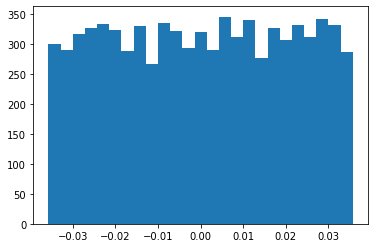

In [23]:
import matplotlib.pyplot as plt
# count equal values in weight tensor
torch.unique(weights, return_counts=True)
# plot the histogram of the weight tensor
plt.hist(weights.detach().flatten(), bins=25)
# weight_hist = torch.histogram(weights.detach(), bins=50)
# plot the histogram
# plt.plot(weight_hist[1][:-1], weight_hist[0])

In [24]:
def get_cmap(n, name='hsv'):
    '''Returns a function that maps each index in 0, 1, ..., n-1 to a distinct 
    RGB color; the keyword argument name must be a standard mpl colormap name.'''
    return plt.cm.get_cmap(name, n)

In [25]:
# get the minimum FP32 value
min_fp32 = np.finfo(np.float32).min
print(min_fp32)
# get the maximum FP32 value
max_fp32 = np.finfo(np.float32).max
print(max_fp32)
# get the minimum positive FP32 value
min_pos_fp32 = np.nextafter(np.float32(0), np.float32(1))
print(min_pos_fp32)
# get the minimum negative FP32 value
min_neg_fp32 = np.nextafter(np.float32(0), np.float32(-1))
print(min_neg_fp32)
zero_fp32 = np.float32(0)
print(zero_fp32)

-3.4028235e+38
3.4028235e+38
1e-45
-1e-45
0.0


initial weights shape: torch.Size([10, 784])
initial biases shape: torch.Size([10])


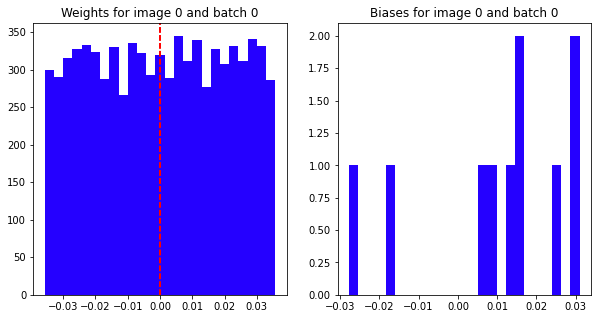

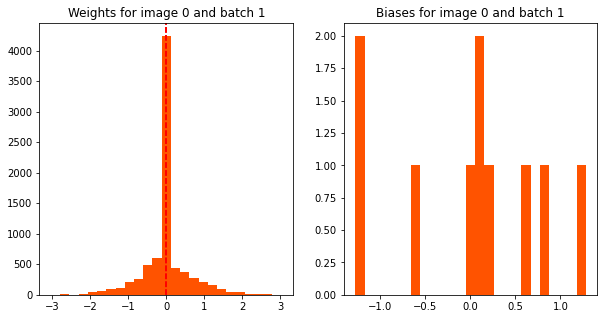

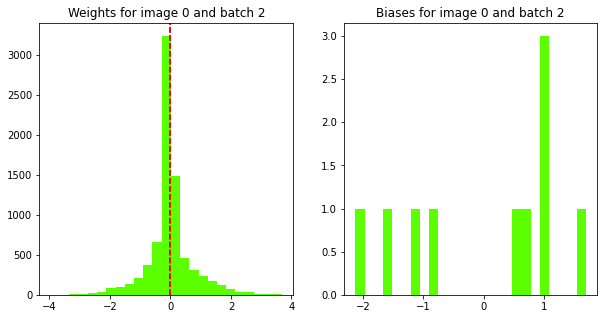

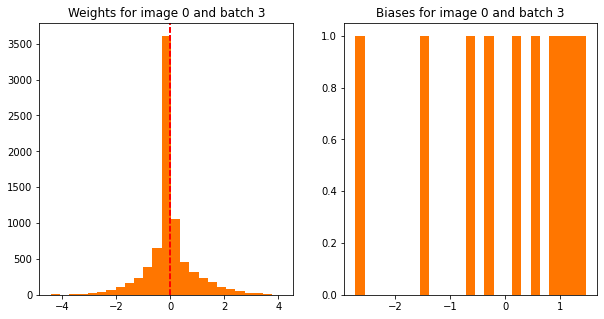

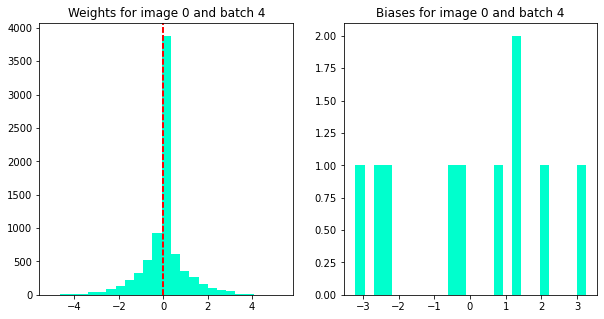

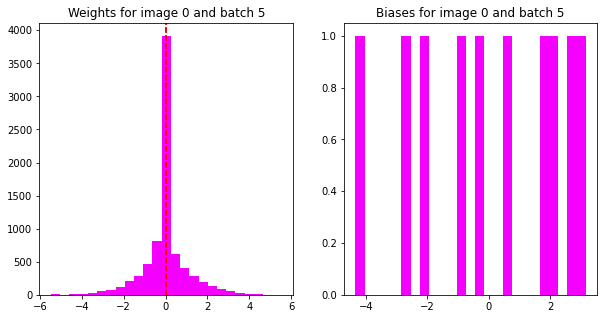

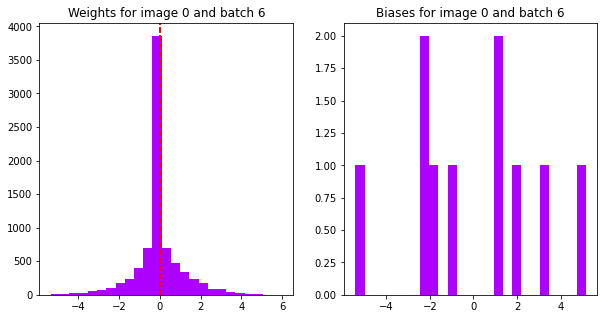

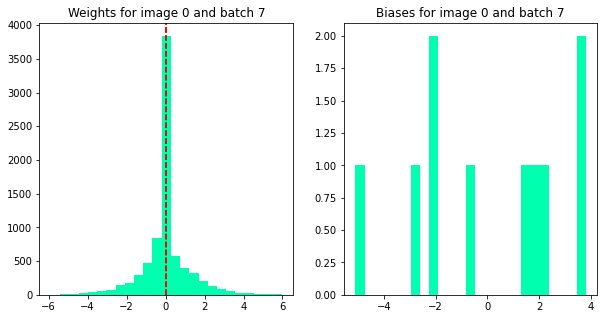

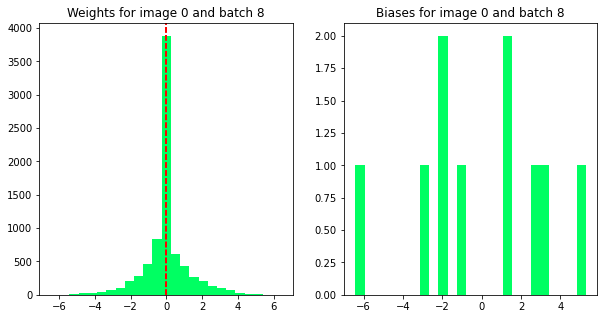

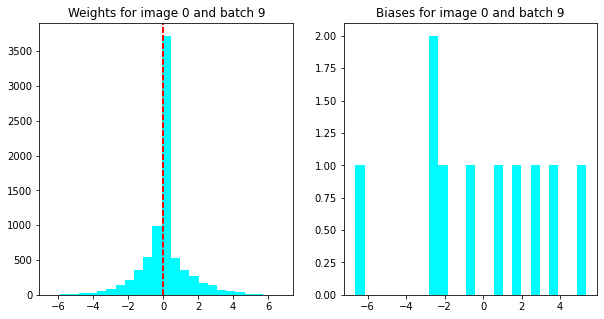

In [26]:
# DRAW HISTOGRAM OF WEIGHTS
# import optimizers
import torch.optim as optim
torch.manual_seed(42)

# make plot larger
plt.rcParams['figure.figsize'] = [10, 5]

net = LinLayer()
weights = net.lin.weight
print("initial weights shape: {}".format(weights.shape))
biases = net.lin.bias
print("initial biases shape: {}".format(biases.shape))

# define the optimizer
optimizer = optim.SGD(net.parameters(), lr=0.5)

# define the loss function
loss_fn = torch.nn.CrossEntropyLoss()

num_batches = 10
it = iter(mnist_dl)
batch_size = 256
cm = get_cmap(batch_size)
for j in range(num_batches):
    rand_idx = np.random.randint(0, 255)
    for i in range(batch_size):
        # print(f'--------------- Iteration {i} ---------------')
        im, label = next(it)
        net.zero_grad()
        # zero the gradients
        optimizer.zero_grad()

        output = net(im.to(torch.float64))
        weights = net.lin.weight
        biases = net.lin.bias

        if i % (batch_size) == 0:
            # plot histogram of weights and biases next to each other
            fig, (ax1, ax2) = plt.subplots(1, 2)
            # generate a random number from 0 .. BATCH_SIZE
            rand_num = np.random.randint(0, batch_size)
            
            ax1.hist(weights.detach().flatten(), bins=25, color=cm(rand_num))
            # plot minimum FP32 value
            # ax1.axvline(x=min_fp32, color='r', linestyle='--')
            # plot maximum FP32 value
            # ax1.axvline(x=max_fp32, color='r', linestyle='--')
            # plot minimum positive FP32 value
            ax1.axvline(x=min_pos_fp32, color='r', linestyle='--')
            # plot minimum negative FP32 value
            ax1.axvline(x=min_neg_fp32, color='r', linestyle='--')
            # plot zero FP32 value
            ax1.axvline(x=zero_fp32, color='r', linestyle='--')
            ax1.set_title('Weights for image {} and batch {}'.format(i, j))
            ax2.hist(biases.detach().flatten(), bins=25, color=cm(rand_num))
            ax2.set_title('Biases for image {} and batch {}'.format(i, j))
            plt.show()

        loss = loss_fn(output, label)
        loss.backward()

        # update the parmeters
        optimizer.step()
        # print(f'--------------- Iteration {i} completed --------------- \n')


In [8]:
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.animation as animation

# Fixing random state for reproducibility
np.random.seed(19680801)
# Fixing bin edges
HIST_BINS = np.linspace(-4, 4, 100)

# histogram our data with numpy
data = np.random.randn(1000)
n, _ = np.histogram(data, HIST_BINS)

In [16]:
n

array([ 0,  0,  0,  0,  1,  1,  0,  0,  0,  0,  2,  0,  0,  0,  0,  2,  0,
        1,  2,  0,  3,  5,  1,  0,  2,  3,  6,  6,  2,  7,  9,  8, 13, 11,
       13, 25, 12, 17, 21, 23, 21, 32, 32, 31, 28, 26, 27, 36, 37, 32, 28,
       38, 23, 25, 25, 29, 33, 24, 31, 27, 23, 17, 21, 23, 20,  7, 13, 18,
        8, 15,  9,  5,  8,  8,  5,  7,  2,  1,  1,  1,  2,  0,  2,  0,  1,
        0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0])